# 等离子体波动分析

In [1]:
import numpy as np
from prettytable import PrettyTable
import os
import matplotlib.pyplot as plt
import plasmapy
import scipy.signal
import scipy.optimize as op
%config InlineBackend.figure_format = 'svg'

# Function definition

In [2]:
def PDR(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta_e = wc / k /vt_e
    zeta_i = wc / k /vt_i
    re = 1 / k**2 / l_e**2 * ( 1 + zeta_e*plasmapy.dispersion.plasma_dispersion_func(zeta_e) )
    ri = 1 / k**2 / l_i**2 * ( 1 + zeta_i*plasmapy.dispersion.plasma_dispersion_func(zeta_i) )
    r = 1 + re + ri 
    return [r.real,r.imag]

def PDR_LW(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta_e = wc / k /vt_e
    re = 1 / k**2 / l_e**2 * ( 1 + zeta_e*plasmapy.dispersion.plasma_dispersion_func(zeta_e) )
    r = 1 + re
    return [r.real,r.imag]

def PDR_IAW(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta_i = wc / k /vt_i
    r = 1 + Te/Ti*( 1 + zeta_i*plasmapy.dispersion.plasma_dispersion_func(zeta_i) )
    return [r.real,r.imag]

def line(p, x):
    k, b = p
    return k*x+b

def errorWithLine(p, x, y):
    r = line(p, x)-y
    return r

def period(x):
    return (x[1]-x[0])/1.

def errPercent(a, b):
    r = abs(a-b)/b
    return r

def fm(v, t):
    r = np.sqrt(1./(2.*np.pi*t))*np.exp(-v**2/(2*t))
    return r

## Parameters settings

In [123]:
k = 1.0
L = 2*np.pi/k
nx_grids = 600
n_per_cell = 1000

vmax = 5. # 速度最大值
max_steps = 600  # 最大时间步数
data_num=2
dt = 0.1
path = '../../data/'
d = 0.1

# 等离子体参量
Te = 1  # 温度
me = 1
Ne = nx_grids*n_per_cell
qe = np.sqrt(L/Ne) #nq^2=1
vt_e = np.sqrt(2*Te/me)
l_e = np.sqrt(Te)
wp_e = np.sqrt(1.0/me)

Ti = 1
mi = 300
Ni = nx_grids*n_per_cell
qi = np.sqrt(L/Ni)
vt_i = np.sqrt(2*Ti/mi)
l_i = np.sqrt(Ti)
wp_i = np.sqrt(1.0/mi)

w_lw = wp_e*(1+1.5*k**2*l_e**2)
w_iaw= wp_i*k*l_e/np.sqrt(1+k**2*l_e**2)
print(w_lw)
print(w_iaw)

2.5
0.040824829046386304


## Dispersion
$$1 +\frac{1}{ k^2 \lambda_e^2 } [1+\zeta_e Z(\zeta_e)]+ \frac{1}{ k^2 \lambda_i^2 } [1+\zeta_i Z(\zeta_i)]=0$$
- 其中$\zeta_{e,i}=\omega/kv_{te,i}$，$v_{te,i}=\sqrt{2kT_{e,i}/m_{e,i}}$

In [124]:
print("k = ",k)
# s=op.root(lambda w:PDR_IAW(w,k),[0.44,-0.4])
# s=op.root(lambda w:PDR_LW(w,k),[1.00,-0.0])
# s=op.root(lambda w:PDR(w,k),[0.3,-0.12])
s=op.root(lambda w:PDR(w,k),[0.18,-0.1231])
w_theo = s.x[0]
r_theo = s.x[1]
print(s.success)
print("w_r = ",s.x[0])
print("w_i = ",s.x[1])
print("|w_i/w_r| = ",abs(s.x[1]/s.x[0]))

k =  1.0
True
w_r =  0.18592063627294053
w_i =  -0.1552392606465497
|w_i/w_r| =  0.8349759540336927


In [125]:
kvec = np.arange(0.1,1.5,0.1)
table = PrettyTable(['k*l_D','w_lw','r_lw','w_iaw','r_iaw','r_iaw/r_lw'])
w_iaw_guess = w_iaw
r_iaw_guess = -0.0085
for ki in kvec:
    s_lw=op.root(lambda w:PDR_LW(w,ki),[1,0.1])
#     s_lw=op.root(lambda w:PDR(w,ki),[s_lw_guess.x[0],s_lw_guess.x[1]])
    s_iaw_guess=op.root(lambda w:PDR_IAW(w,ki),[w_iaw_guess,r_iaw_guess])
    s_iaw=op.root(lambda w:PDR(w,ki),[s_iaw_guess.x[0],s_iaw_guess.x[1]])
    kl=round(ki*l_e,6)
    w_lws=round(s_lw.x[0],6)
    r_lws=round(s_lw.x[1],6)
    w_iaws=round(s_iaw.x[0],6)
    r_iaws=round(s_iaw.x[1],6)
    wr_ratio=abs(round(r_lws/r_iaws,6))
    w_iaw_guess = w_iaws
    r_iaw_guess = r_iaws
    table.add_row([kl,w_lws,r_lws,w_iaws,r_iaws,wr_ratio])
print(table)

+-------+----------+-----------+----------+-----------+------------+
| k*l_D |   w_lw   |    r_lw   |  w_iaw   |   r_iaw   | r_iaw/r_lw |
+-------+----------+-----------+----------+-----------+------------+
|  0.1  | 1.015198 |    -0.0   | 0.011985 | -0.005448 |    0.0     |
|  0.2  | 1.063984 |  -5.5e-05 | 0.023817 | -0.010998 |  0.005001  |
|  0.3  | 1.159846 |  -0.01262 | 0.035367 | -0.016747 |  0.753568  |
|  0.4  | 1.285057 | -0.066128 | 0.046534 | -0.022782 |  2.902642  |
|  0.5  | 1.415662 | -0.153359 | 0.057262 | -0.029177 |  5.256161  |
|  0.6  | 1.545707 |  -0.26411 | 0.067527 | -0.035986 |  7.339243  |
|  0.7  | 1.673866 | -0.392401 | 0.077335 | -0.043243 |  9.074324  |
|  0.8  | 1.799899 | -0.534552 | 0.086714 | -0.050967 | 10.488198  |
|  0.9  | 1.923865 | -0.688109 | 0.095699 | -0.059159 | 11.631518  |
|  1.0  | 2.045905 |  -0.85133 | 0.104331 | -0.067811 | 12.554453  |
|  1.1  | 2.166175 | -1.022919 | 0.11265  | -0.076905 | 13.301073  |
|  1.2  | 2.284825 | -1.201876 | 0

In [126]:
dataet = np.loadtxt(os.path.join(path,"tot_energy"))
dataep = np.loadtxt(os.path.join(path,"pot_energy"))
dataek = np.loadtxt(os.path.join(path,"kin_energy"))

t = np.linspace(0, max_steps, max_steps+1)

In [106]:
indexes, _ = scipy.signal.find_peaks(dataep, distance=10, height = 1e-6)
xep = indexes[0:2:1]
yep = np.log(dataep[xep])
para, nouse = op.leastsq(errorWithLine, [-1, 1], args=(xep, yep))
per_sim = period(xep) * dt
# Ep ~ E^2 ~ Exp(i 2 w t + 2 r t)
w_sim = 2*np.pi/per_sim/2
r_sim = para[0]/dt/2
wc_table=PrettyTable(['w_theo','w_sim','err w(%)','r_theo','r_sim','err r(%)'])
wc_table.add_row([w_theo,w_sim,errPercent(w_sim,w_theo)*100,r_theo,r_sim,errPercent(r_sim,r_theo)*100])
print(wc_table)

+---------------------+---------------------+--------------------+---------------------+----------------------+---------------------+
|        w_theo       |        w_sim        |      err w(%)      |        r_theo       |        r_sim         |       err r(%)      |
+---------------------+---------------------+--------------------+---------------------+----------------------+---------------------+
| 0.21039058162875085 | 0.23620997395411977 | 12.272123649968837 | -0.1525262111136668 | -0.18548768842556493 | -21.610369176045634 |
+---------------------+---------------------+--------------------+---------------------+----------------------+---------------------+


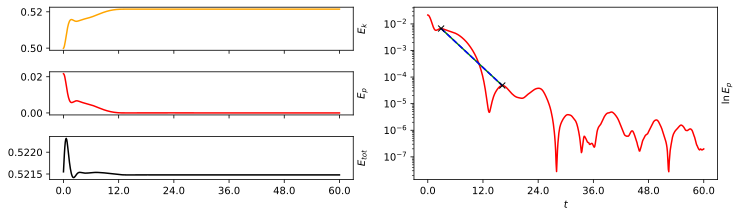

In [107]:
fig = plt.figure(figsize=(12, 3))
time_ticks = np.linspace(0,max_steps,num=6)

ax1 = plt.subplot2grid((3, 2), (0, 0))
ax1.plot(t, dataek, color='orange')
ax1.set_ylabel(r'$E_k$')
ax1.yaxis.set_label_position("right")
plt.xticks(time_ticks,[])

ax2 = plt.subplot2grid((3, 2), (1, 0))
ax2.plot(t, dataep, color='r')
ax2.set_ylabel(r'$E_p$')
ax2.yaxis.set_label_position("right")
plt.xticks(time_ticks,[])

ax3 = plt.subplot2grid((3, 2), (2, 0))
ax3.plot(t, dataet, color='black')
ax3.set_ylabel(r'$E_{tot}$')
ax3.yaxis.set_label_position("right")
plt.xticks(time_ticks,time_ticks*dt)

axl2 = plt.subplot2grid((3, 2), (0, 1), rowspan=3)
axl2.plot(t, dataep, color='r')
axl2.plot(xep,np.exp(line(para,xep)), '-',color='green')
axl2.plot(xep,np.exp(r_sim*xep*dt*2+para[1]), '--',color='blue')
axl2.plot(xep,dataep[xep], 'x',color='black')
axl2.set_ylabel(r'$\ln E_p$')
axl2.set_yscale('log')
axl2.yaxis.set_label_position("right")
plt.xticks(time_ticks,time_ticks*dt)

fig.subplots_adjust(bottom=0.1, top=0.9, hspace=.5, wspace=.2)
plt.xlabel(r'$t$')
plt.show()